In [1]:
import pandas as pd
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras import layers
import time
import timeit
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from statistics import mean 
import requests
from datetime import date, timedelta

C:\Users\Mihan Perera\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def sentiment_score(symbol, date):
    pipe = pipeline("text-classification", model="ProsusAI/finbert")
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
    score = []
    stock_news_tables = {'AAPL': 'AAPL.json', 'TSLA': 'TSLA.json', 'MSFT': 'MSFT.json', 'NVDA': 'NVDA.json'}
    filename = stock_news_tables.get(symbol)
    
    if filename is not None:
        # Open and read the JSON data from the file
        with open(filename, 'r') as file:
            data = json.load(file)
            score = []  # Initialize the score list as an empty list 
            titles = []

            for i in range(len(data)):   
                for j in range(len(data[i]['articles'])):
                    #print(data[i]['articles'][j]['publishedAt'])
                    if date == data[i]['articles'][j]['publishedAt']:
                        titles.append(data[i]['articles'][j]['title'])
         
            for k in range(len(titles)): 

                res = pipe(titles[k])
                if res[0]['label'] == 'positive':
                    score.append(res[0]['score'])  # Append 'score' from 'res' to the 'score' list
                if res[0]['label'] == 'negative':
                    score.append(-res[0]['score'])
                if res[0]['label'] == 'neutral':
                    score.append(0*res[0]['score'])
    else:
        # Handle the case where the symbol is not found in the dictionary
        print(f"Symbol '{symbol}' not found in stock_news_tables")
    if score == []:
        return 0
    else:
        return mean(score)

In [3]:

import keras
class Time2Vec(keras.layers.Layer):
    def __init__(self, kernel_size=1):
        super(Time2Vec, self).__init__(trainable=True, name='Time2VecLayer')
        self.k = kernel_size
    
    def build(self, input_shape):
        # trend
        self.wb = self.add_weight(name='wb',shape=(input_shape[1],),initializer='uniform',trainable=True)
        self.bb = self.add_weight(name='bb',shape=(input_shape[1],),initializer='uniform',trainable=True)
        # periodic
        self.wa = self.add_weight(name='wa',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
        self.ba = self.add_weight(name='ba',shape=(1, input_shape[1], self.k),initializer='uniform',trainable=True)
        super(Time2Vec, self).build(input_shape)
    
    def call(self, inputs, **kwargs):
        bias = self.wb * inputs + self.bb
        dp = K.dot(inputs, self.wa) + self.ba
        wgts = K.sin(dp) # or K.cos(.)
        #print(wgts,bias)
        ret = K.concatenate([K.expand_dims(bias, -1), wgts], -1)
        ret = K.reshape(ret, (-1, inputs.shape[1]*(self.k+1)))
        #print(ret)
        return ret
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]*(self.k + 1))
        
        

In [4]:
class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """
    def __init__(self, ticker=[], test_size=0.2, period='max', n_input=1, timestep=1) -> None:
        self.ticker = ticker
        self.period = period
        self.test_size = test_size
        self.n_input = n_input
        self.df = self.extract_historic_data()
        self.timestep = timestep
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)
        

    def extract_historic_data(self) -> pd.Series:
        """
        gets historical data from yf api.
        """
        # Define the list of stock symbols
        #stock_symbols = ['AAPL', 'MSFT', 'TSLA', 'NVDA']

        # Fetch historical data using yfinance
        start_date = '2023-10-18'
        end_date = '2023-11-02'
        delta = timedelta(days=1)
        
        # Create an empty DataFrame
        df = pd.DataFrame()

        # Fetch and append closing prices for each stock
        for symbol in self.ticker:
            stock_data = yf.download(symbol, start=start_date, end=end_date)
            df[symbol] = stock_data['Close']
        #print(df)  
        return df

    def split_data(self) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        data = self.extract_historic_data()
        
        if len(data) != 0:
            train_idx = round(len(data) * (1-self.test_size))
            train = data[:train_idx]
            test = data[train_idx:]
            train = np.array(train)
            test = np.array(test)
            #print(train[:, np.newaxis])
            return train[:, np.newaxis], test[:, np.newaxis]
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs,
        namely, [# samples, timestep, # feautures]
        samples
        """
        NUM_FEATURES = 4
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
       # print(result)
        return result.reshape((samples, self.timestep, NUM_FEATURES))

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        return self.window_and_reshape(train), self.window_and_reshape(test)
    
    def sentiment_ana(self, train, stocks, i):
        sentiment = [] 
        num_rows = train.shape[0]*train.shape[1]
        # Create a column of twos
        stock_ticker_val = np.full((num_rows, 1), i+1)

        #print(train.shape)
        #print(stock_ticker_val.shape)
        start_date = date(2023, 10, 18)
        end_date = date(2023, 11, 2)
        delta = timedelta(days=1)
        past_data = self.df
       # print(past_data)
        while start_date <= end_date:
            #print(start_date.strftime("%Y-%m-%d"))
            dates = start_date.strftime("%Y-%m-%d")
            if dates in past_data.index:                     #figure out a way to get the date
                res = sentiment_score(stocks[i], dates)
               # print(res)
                sentiment.append(res)
            start_date += delta

        senti_array = []
        if (np.array(sentiment).shape[0]/2) > train.shape[0]:
            senti_array = sentiment[-train.shape[0]:]
            #print(train.shape[0])
        else:
            senti_array = sentiment[:train.shape[0]]
            #print(np.array(senti_array).shape[0])

        new_sent = np.array(senti_array).reshape((num_rows,1))
        # Concatenate the original array and the twos column horizontally
        new_array = train[:, :, i].reshape((train.shape[0]*train.shape[1],1))
        reshaped_array = np.hstack((new_array, new_sent, stock_ticker_val)) #add the sentiment analysis here
        return reshaped_array
    
    def etl(self) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data()
        return self.transform(train, test)


    def to_supervised(self, train, n_out=1) -> tuple:
        """
        Converts our time series prediction problem to a
        supervised learning problem.
        """
        # flatted the data
        #print(train.shape[0], train.shape[1], train.shape[2])
        stocks = self.ticker
        num_stocks = len(stocks)
        data_x = []
        data_y = [] 
        data_new = []
        
        for i in range(len(self.ticker)):
                                          
            #reshaped_array = new_array.reshape((new_array.shape[0]*train.shape[1], train.shape[2]))
            '''
            sentiment = [] 
            num_rows = train.shape[0]*train.shape[1]
            # Create a column of twos
            stock_ticker_val = np.full((num_rows, 1), i+1)

            #print(train.shape)
            #print(stock_ticker_val.shape)
            start_date = date(2023, 10, 18)
            end_date = date(2023, 11, 2)
            delta = timedelta(days=1)

            while start_date <= end_date:
                #print(start_date.strftime("%Y-%m-%d"))
                dates = start_date.strftime("%Y-%m-%d")
                if dates in self.df.index:                     #figure out a way to get the date
                    res = sentiment_score(stocks[i], dates)
                    print(res)
                    sentiment.append(res)
                start_date += delta

            senti_array = []
            if (np.array(sentiment).shape[0]/2) > train.shape[0]:
                senti_array = sentiment[-train.shape[0]:]
                #print(train.shape[0])
            else:
                senti_array = sentiment[:train.shape[0]]
                #print(np.array(senti_array).shape[0])

            new_sent = np.array(senti_array).reshape((num_rows,1))
            # Concatenate the original array and the twos column horizontally
            new_array = train[:,:, i].reshape((train.shape[0]*train.shape[1],1))
            reshaped_array = np.hstack((new_array, new_sent, stock_ticker_val)) #add the sentiment analysis here
            '''
            
            reshaped_array = self.sentiment_ana(train, stocks, i)
            X, y = [], []
            in_start = 0
            
            # step over the entire history one time step at a time
            for _ in range(len(reshaped_array)):
                # define the end of the input sequence
                in_end = in_start + self.n_input
                out_end = in_end + n_out
                # ensure we have enough data for this instance
                if out_end <= len(reshaped_array):
                    x_input = reshaped_array[in_start:in_end, :]
                    x_input = x_input.reshape((len(x_input), 3))
                    #print(x_input)
                    X.append(x_input)
                    y.append(reshaped_array[in_end:out_end, 0])
                    # move along one time step
                    in_start += 1
                    #print(X)
            data_x.append(X)
            data_y.append(y)
        data_x = np.array(data_x)
        #print(data_x.shape)
        data_y = np.array(data_y)
       # print(data_y.shape)
        return data_x, data_y

In [5]:
class PredictAndForecast():
    """
    model: tf.keras.Model
    train: np.array
    test: np.array
    Takes a trained model, train, and test datasets and returns predictions
    of len(test) with same shape.
    """
    def __init__(self, model, train, test, n_input=1) -> None:
        self.model = model
        self.train = train
        self.test = test
        self.n_input = n_input
        self.predictions = self.get_predictions()


    def forecast(self, history) -> np.array:
        
        """
        Given last weeks actual data, forecasts next weeks prices.
        """
        # flatten data
        data = np.array(history)
                            
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        # retrieve last observations for input data
        input_x = data[-self.n_input:, :]
      
        # reshape into [1, n_input, 1]
        input_x = input_x.reshape((1, len(input_x), input_x.shape[1]))
       # print(input_x)
        # forecast the next week
        yhat = self.model.predict(input_x, verbose=0)
        # we only want the vector forecast
        yhat = yhat[0]
        return yhat
        
    def get_predictions(self) -> np.array:
        """
        compiles models predictions week by week over entire
        test set.
        """
        # history is a list of weekly data
        history = [x for x in self.train]
        # walk-forward validation over each week
        predictions = []
        for i in range(len(self.test)):
            yhat_sequence = self.forecast(history)
            # store the predictions
            predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
            history.append(self.test[i, :])
        #print(np.array(predictions))
        return np.array(predictions)

In [6]:
class Evaluate:

  def __init__(self, actual, predictions) -> None:
    
    #print(predictions.shape)
    self.actual = actual[:,:,0]
    self.predictions = predictions
    self.var_ratio = self.compare_var()
    self.mape = self.evaluate_model_with_mape()

  def compare_var(self):
    return abs( 1 - (np.var(self.predictions) / np.var(self.actual)))

  def evaluate_model_with_mape(self):
    return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

In [7]:
data = ETL(['AAPL', 'MSFT', 'TSLA', 'NVDA'])
#data.df.reset_index(inplace=True)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [16]:
def gated_residual_network(inputs, hidden_dim):
    x = layers.LayerNormalization()(inputs)
    
    g1 = layers.Dense(hidden_dim, activation="linear")(x)
    g2 = layers.Dense(hidden_dim, activation="elu")(x)
    
    g = layers.multiply([g1, g2])
    g = layers.Dense(x.shape[-1])(g)
    grn_output = layers.add([x, g])
    
    return grn_output

In [17]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=epsilon)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

  grn_output = gated_residual_network(res, ff_dim)
#1 Gated Feed Forward Part
 # x = layers.LayerNormalization(epsilon=epsilon)(res)
 # x = gated_residual_block(x, 3)
 # x = layers.LayerNormalization(epsilon=epsilon)(x)
 # ff_output = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  #ff_output = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(ff_output)
    
# Gated Residual Connection
 # gated_output = keras.layers.multiply([ff_output, res])
 
  #3 Gated Residual Connection
  #print(res.shape[-2])
  #x = GatedResidualNetwork(input_dim=res.shape[-2], hidden_dim=256, output_dim=res.shape[-2])(res)
    
 # Feed Forward Part
  x = layers.LayerNormalization(epsilon=epsilon)(grn_output)
  x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
  return x + res
  

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
  """
  Creates final model by building many transformer blocks.
  """

  n_timesteps, n_features, n_outputs = 1, 3, 1
  time2vec = Time2Vec(kernel_size=1)

  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  time_embedding = keras.layers.TimeDistributed(time2vec)(inputs)
  x = K.concatenate([inputs, time_embedding], -1)
  
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)
    
  #portfolio_weights = CustomOutputLayer()(x)
  #return tf.keras.Model(inputs, portfolio_weights)
  outputs = layers.Dense(n_outputs)(x)
  return tf.keras.Model(inputs, outputs)

In [18]:
transformer = build_transfromer(head_size=256, num_heads=12, ff_dim=128, num_trans_blocks=4, mlp_units=[512], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

In [19]:
transformer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1, 3)]       0           []                               
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 1, 6)        12          ['input_2[0][0]']                
 buted)                                                                                           
                                                                                                  
 tf.concat_1 (TFOpLambda)       (None, 1, 9)         0           ['input_2[0][0]',                
                                                                  'time_distributed_1[0][0]']     
                                                                                            

In [20]:
def fit_transformer(transformer: tf.keras.Model):
  """
  Compiles and fits our transformer.
  """
  transformer.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mae", 'mape'])
  
  print(data.X_train.shape[0])
  hist = 0 
  for stocks in range(data.X_train.shape[0]):
      callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
      start = time.time()
      hist = transformer.fit(data.X_train[stocks], data.y_train[stocks], batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
      print(time.time() - start)
  return hist

In [21]:
hist = fit_transformer(transformer)

4
Epoch 1/25
1/1 [==============================] - 10s 10s/step - loss: 29957.8711 - mae: 173.0642 - mape: 100.9662
Epoch 2/25
1/1 [==============================] - 0s 58ms/step - loss: 29815.5586 - mae: 172.6536 - mape: 100.7275
Epoch 3/25
1/1 [==============================] - 0s 57ms/step - loss: 29613.5820 - mae: 172.0639 - mape: 100.3808
Epoch 4/25
1/1 [==============================] - 0s 57ms/step - loss: 29469.8633 - mae: 171.6473 - mape: 100.1389
Epoch 5/25
1/1 [==============================] - 0s 59ms/step - loss: 29314.8828 - mae: 171.1945 - mape: 99.8741
Epoch 6/25
1/1 [==============================] - 0s 53ms/step - loss: 29265.9609 - mae: 171.0508 - mape: 99.7896
Epoch 7/25
1/1 [==============================] - 0s 51ms/step - loss: 29193.3906 - mae: 170.8404 - mape: 99.6680
Epoch 8/25
1/1 [==============================] - 0s 57ms/step - loss: 29120.3164 - mae: 170.6270 - mape: 99.5438
Epoch 9/25
1/1 [==============================] - 0s 62ms/step - loss: 28999.4863 

In [22]:
def convert_preds(dataa, timestep, NUM_FEATURES, ticker):
    """
    Given last weeks actual data, forecasts next weeks prices.
    """
    data_new = []

    for i in range(len(ticker)):
        reshaped_data = data.sentiment_ana(dataa, ticker, i)
        samples = int(reshaped_data.shape[0] / timestep)
        result = np.array(np.array_split(reshaped_data, samples))
    
        data_new.append(result.reshape((samples, timestep, NUM_FEATURES)))
        
        
    return np.array(data_new)


In [23]:
start = time.time()
train = convert_preds(data.train, data.timestep, 3, data.ticker)
test = convert_preds(data.test, data.timestep, 3, data.ticker)
predict = []
for i in range(len(data.ticker)):
    predict.append(PredictAndForecast(transformer, train[i], test[i]))
    print(time.time() - start)

413.4799265861511
413.6057207584381
413.72831106185913
413.8509211540222


In [24]:
print(predict[0].predictions)

[[395.71426]
 [395.69742]]


In [25]:
for i in range(len(data.ticker)):
    transformer_evals = Evaluate(test[i], predict[i].predictions)
    print(f'{data.ticker[i]} transformer_evals.var_ratio: {transformer_evals.var_ratio}')
    print(f'{data.ticker[i]} transformer_evals.mape: {transformer_evals.mape}')

AAPL transformer_evals.var_ratio: 0.9999722872797813
AAPL transformer_evals.mape: 1.2958752143234713
MSFT transformer_evals.var_ratio: 0.9998997959201611
MSFT transformer_evals.mape: 0.25226842580510617
TSLA transformer_evals.var_ratio: 0.9755670137165503
TSLA transformer_evals.mape: 0.9735102316621203
NVDA transformer_evals.var_ratio: 0.9978212535084322
NVDA transformer_evals.mape: 0.06623266268927176


In [44]:
def plot_results(test, preds, df, image_path=None, title_suffix=None, xlabel=None):
  """
  Plots training data in blue, actual values in red, and predictions in green,
  over time.
  """
  fig, ax = plt.subplots(figsize=(20,6))
  # x = df.Close[-498:].index
  plot_test = test[1:,:,0]
  print(plot_test)
  #print(plot_test)
 
  plot_preds = preds[1:]
  #print(plot_preds)
  x = df.index[-(plot_test.shape[0] * plot_test.shape[1]):]
  #print(x)
  plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  ax.plot(x, plot_test, label='actual')
  ax.plot(x, plot_preds, label='preds')
    
  if title_suffix is None:
    ax.set_title('Predictions vs. Actual')
  else:
    ax.set_title(f'Predictions vs. Actual, {title_suffix}')

  ax.set_xlabel('Date')
  ax.set_ylabel(xlabel)
  ax.legend()

  if image_path is not None:
    imagedir = '/content/drive/MyDrive/Colab Notebooks/images'
    plt.savefig(f'{imagedir}/{image_path}.png')
  plt.show()

[[173.97000122]]


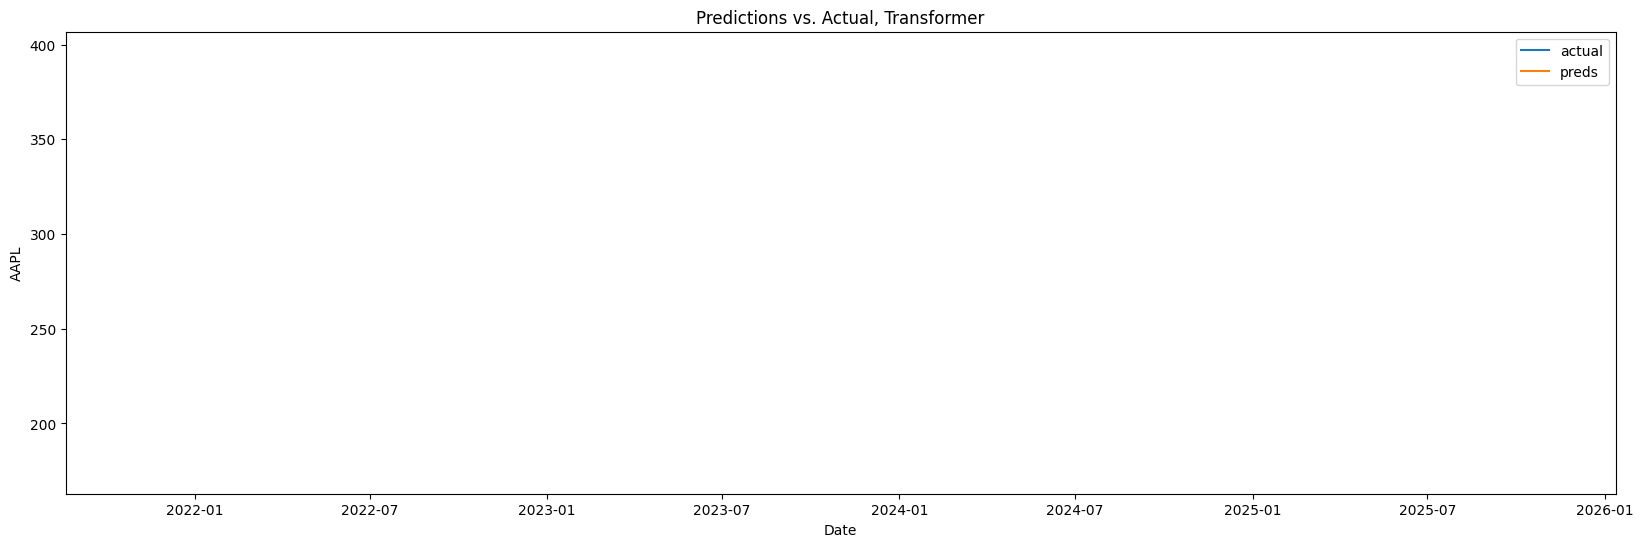

[[346.07000732]]


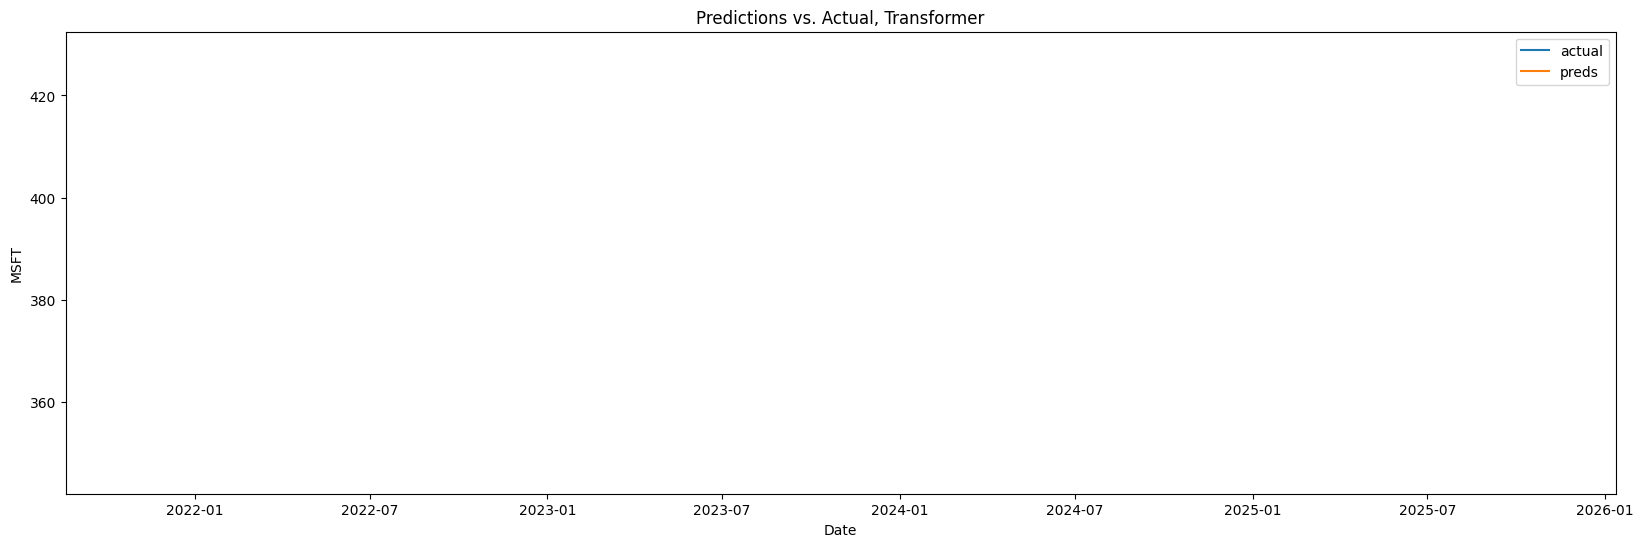

[[205.66000366]]


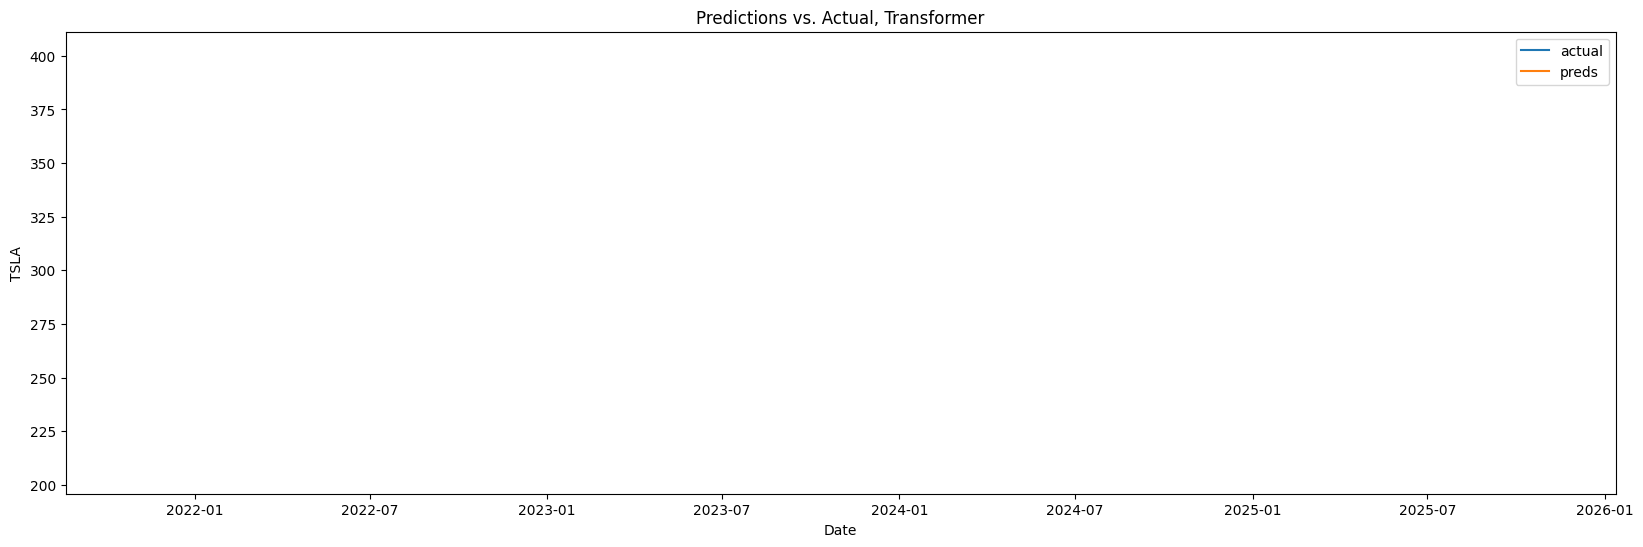

[[423.25]]


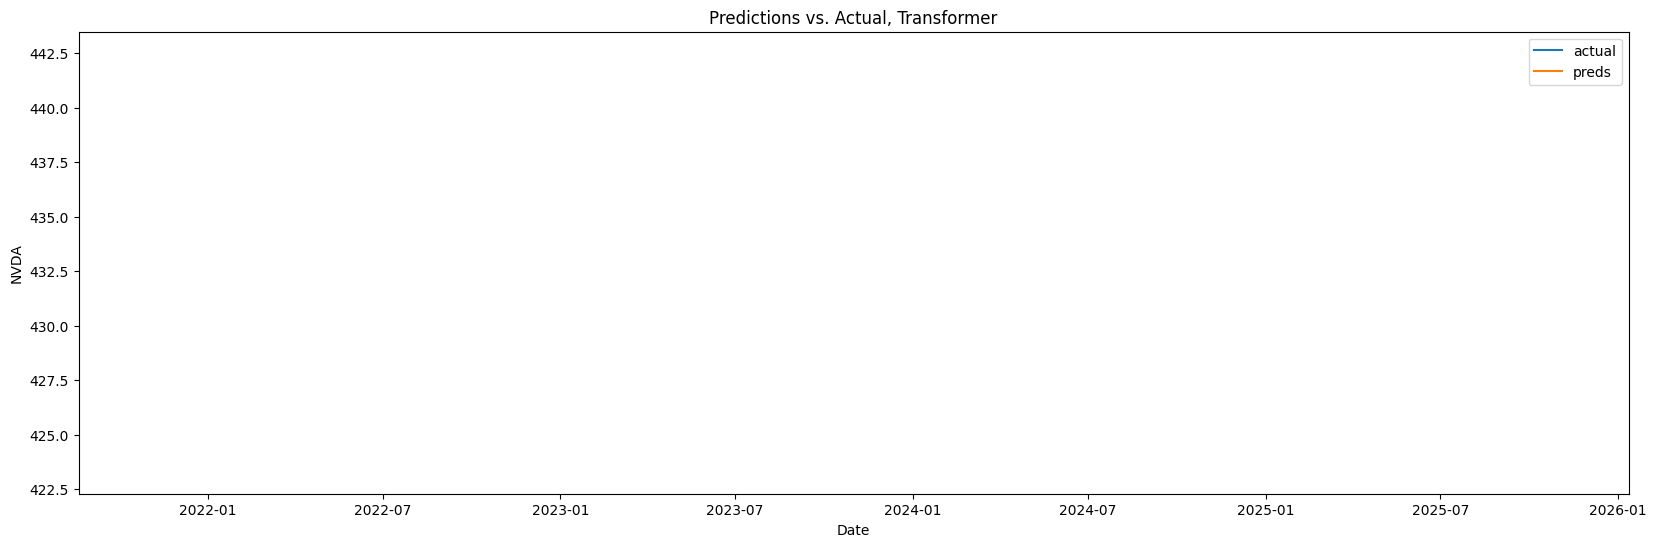

In [45]:
for i in range(len(data.ticker)):
    plot_results(test[i], predict[i].predictions, data.df[data.df.columns[i]], title_suffix='Transformer', xlabel = data.df.columns[i])
